In [12]:
import matplotlib.pyplot as plt  # matplotlib for some plotting
import numpy as np  # numeric python functions
import pandas as pd  # need this to load our data from the csv files

from pyconturb import gen_turb, gen_spat_grid, TimeConstraint  # generate turbulence, useful helper
from pyconturb.sig_models import iec_sig  # IEC 61400-1 turbulence std dev
from pyconturb.spectral_models import kaimal_spectrum  # Kaimal spectrum
from pyconturb.wind_profiles import constant_profile, power_profile  # wind-speed profile functions

from _nb_utils import plot_slice
import h5py

## Constrained Turbulence ##
copied from [PyConTurb example](https://pyconturb.pages.windenergy.dtu.dk/pyconturb/notebooks/3_constr_time_series.html)

### Step 1: generate dataframe of measurement data ###

In [13]:
# sonic position
x_sonic1 = 0.0
y_sonic1 = 4.5
z_sonic1 = 2.23 # m above ground

sonic_spat_df = gen_spat_grid(y_sonic1, z_sonic1)  # if `comps` not passed in, assumes all 3 components are wanted
sonic_spat_df.head()  # look at the first few rows

,u_p0,v_p0,w_p0
k,0.00,1.00,2.00
x,0.00,0.00,0.00
y,4.50,4.50,4.50
z,2.23,2.23,2.23


In [14]:
# m2 tower data
m2 = {}
m2['u'] = [9.3218, 10.212, 11.211]
m2['z'] = [2, 5, 10]
m2['w_dir'] = [282.07, 275.67, 275.35]
m2['Iu'] = [0.1542, 0.149, 0.1455]

In [15]:
pwd

'/kfs2/projects/pvopt/brooke/duramat-validation-turbinflow/pyconturb/pyconturb-pvade'

In [16]:
# def read_csv_data(sonic_data_fn, dt_sonic1):
def read_csv_data(raw_data):
    # read csv
    # raw_data = pd.read_csv(sonic_data_fn, header=None)

    # select only sonic data columns
    sonic_data = raw_data[['u (m/s)', 'v (m/s)', 'w (m/s)']]

    # downsample from 50 Hz to 4 Hz (sonic resolution)
    # sonic_data = sonic_data.resample('250ms').median() # 4 Hz = 250 milliseconds

    # construct time index
    tmp = (sonic_data.index[1]-sonic_data.index[0])
    dt_sonic1 = round(tmp.total_seconds(), 3)
    # print(dt_sonic1)
    tf_sonic1 = len(sonic_data) * dt_sonic1 # final time [s]
    # print(tf_sonic1)
    t_sonic1 = np.arange(0.0, tf_sonic1, dt_sonic1)

    sonic_data = sonic_data.rename(columns={'u (m/s)':'u_p0', 'v (m/s)':'v_p0', 'w (m/s)':'w_p0'})
    for col in sonic_data.filter(regex='u_', axis=1).columns:
        sonic_data[col] = -1.0*sonic_data[col] # to make it positive from the west
    sonic_data['index'] = t_sonic1
    sonic_data = sonic_data.set_index('index')

    return tf_sonic1, sonic_data

# sonic_data_fn = 'DuraMAT_tilt40deg_turbulent_inflow_10min_timeseries.csv'
# sonic_data_fn = 'DuraMAT_tiltneg40deg_turbulent_inflow_10min_timeseries.csv'
# sonic_data_fn = 'DuraMAT_tiltneg10deg_turbulent_inflow_10min_timeseries.csv'
sonic_data_fn = 'DuraMAT_tilt10deg_turbulent_inflow_10min_timeseries.csv'

raw_data = pd.read_csv(sonic_data_fn, index_col='Time')
raw_data.index = pd.to_datetime(raw_data.index)

tf_sonic1, sonic_data = read_csv_data(raw_data)
dt = sonic_data.index[1]-sonic_data.index[0]
sonic_data

,u_p0,v_p0,w_p0
index,,,
0.00,5.178524,0.547165,-0.629920
0.02,5.178727,0.547691,-0.629778
0.04,5.178055,0.546756,-0.629750
0.06,5.178951,0.547148,-0.630080
0.08,5.178974,0.547235,-0.629922
...,...,...,...
599.90,8.296480,0.009609,-0.175496
599.92,8.296545,0.008988,-0.175454
599.94,8.296798,0.009004,-0.175349


u_mean =  7.141400274916611


Text(0.5, 0, 'time')

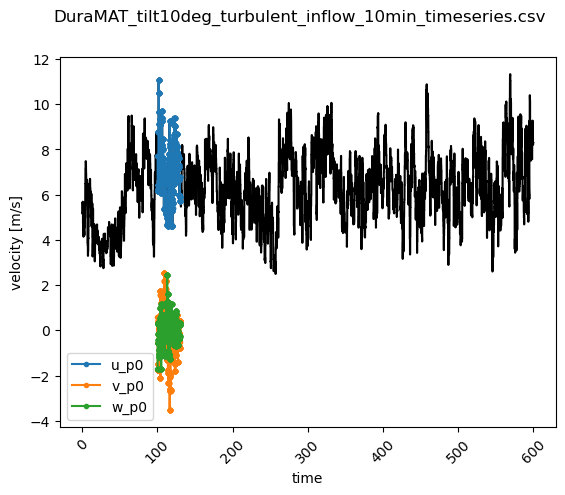

In [17]:
# vel_cols = ['u (m/s)', 'v (m/s)', 'w (m/s)']
# tstart = 0.0
tstart = 100.0
duration = 30.0
tend = tstart+30.0
plt_data = sonic_data[(sonic_data.index > tstart) & (sonic_data.index < tend)] #raw_data.iloc[:60]
base_plt_data = sonic_data
fig, axs = plt.subplots()
plt.suptitle(sonic_data_fn)
for col in plt_data.columns:
    if 'u' in col:
        plt.plot(base_plt_data[col], '-', color='k', label='')  # subselect long. wind component
    plt.plot(plt_data[col], '.-', label=col)  # subselect long. wind component
    # plt.plot(plt_data[col].resample('50ms').median(), 'kx', label=col)  # subselect long. wind component
    # plt.plot(plt_data[col].resample('250ms').median(), 'kx')  # subselect long. wind component
    if 'u' in col:
        print('u_mean = ', plt_data[col].mean())
axs.set_ylabel('velocity [m/s]');
axs.legend()
axs.tick_params(axis='x', rotation=45)
axs.set_xlabel('time')
# axs.set_xlim([100, 200])

In [18]:
# # sanity check 50 Hz data with 20 Hz data
# sonic_data_fns = ['sonic1_10min_20Hz.csv','sonic1_10min_50Hz.csv']

# fig, ax = plt.subplots(figsize=[12,3])
# for fn in sonic_data_fns:
#     dt_check = 1.0/int(fn[13:15])
#     # print(dt_check)
#     tf_check, sonic_data_check = read_csv_data(fn, dt_check)
#     print(len(sonic_data_check))

#     sonic_data_check = sonic_data_check.loc[sonic_data_check.index <= 5.0]

#     t = sonic_data_check.index.values
#     print(t[:10])

#     ax.plot(t,sonic_data_check.filter(regex='u'),'.-',markersize=4,label = fn[13:15]+' Hz')
#     ax.legend()
#     ax.set_ylabel('velocity [m/s]')
#     ax.set_xlabel('time [s]')

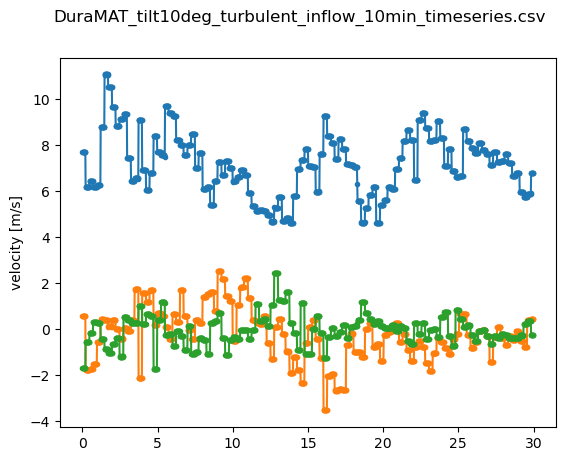

In [19]:
# optional: cut down duration of signal for testing
# tstart = 0.000000
# tstart = 250.000000
# duration = 30.0
# tend = tstart+duration
sonic_data = sonic_data.loc[(sonic_data.index >= tstart) & (sonic_data.index < tend)] #raw_data.iloc[:60]
sonic_data.index = sonic_data.index - tstart

# tf_sonic1 = 30.0 # [s] - this is also how long the synthetic turbulence signal will be
# sonic_data = sonic_data.loc[sonic_data.index <= tf_sonic1]

fig, axs = plt.subplots()
plt.suptitle(sonic_data_fn)
for col in sonic_data.columns:
    plt.plot(sonic_data[col], marker='.', label=col)  # subselect long. wind component
    # plt.plot(sonic_data[col].resample('50L').first(), marker='.', label=col)  # subselect long. wind component
axs.set_ylabel('velocity [m/s]');

sonic_df = pd.concat([sonic_spat_df, sonic_data], axis=0)
# sonic_df.head()

In [20]:
gen_csv_fname = 'generated_{}_{}s_{}Hz.csv'.format(sonic_data_fn[:34],int(duration),int(1/dt))
sonic_df.to_csv(gen_csv_fname)
gen_csv_fname

'generated_DuraMAT_tilt10deg_turbulent_inflow_30s_50Hz.csv'

In [21]:
stop

NameError: name 'stop' is not defined

### Step 2: read in csv of measurement data ###

In [ ]:
con_tc = TimeConstraint(pd.read_csv(gen_csv_fname, index_col=0))  # load data from csv directly into tc
# con_tc = TimeConstraint(pd.read_csv('generated_sonic1_1s.csv', index_col=0))  # load data from csv directly into tc
con_tc.index = con_tc.index.map(lambda x: float(x) if (x not in 'kxyz') else x)  # index cleaning
con_tc.iloc[:7, :]  # look at the first 7 rows

time_df = con_tc.get_time()

# for var in ['u_','v_','w_']:
#     ax = time_df.filter(regex=var, axis=1).plot(lw=0.75)  # subselect long. wind component
#     ax.set_ylabel(var + ' [m/s]');

# [print(x) for x in time_df.filter(regex='u_', axis=1).mean()];  # print mean values
u_mean_sonic1 = time_df.filter(regex='u_', axis=1).mean()
print(f'u_mean_sonic1 = {u_mean_sonic1.values[0]:.3f} m/s')

In [ ]:
con_tc.iloc[:7, :]

### Step 3: generate constrained turbulence box ###

In [ ]:
# define spatial information
# y = np.linspace(-5, 5, 7) #11) #22)  # 11 lateral points from -50 to 50 (center @ 0)
# z = np.linspace(0.5, 10.5, 13) #13) # 26)  # 13 vertical points from 40 to 160 (center @ 100)

# for testing
y_min = -13.1
y_max = 13.1
z_max = 20.0
# ny = 15

# to match pvade sim
l_char = 0.17
ny = int((y_max-y_min)/l_char)
# ny = 300 # 130 #41
# nz = 60 #130 #20

y = np.linspace(y_min, y_max, ny)
# y = np.linspace(-10.0, 10.0, ny) #11) #22)  # 11 lateral points from -50 to 50 (center @ 0)
# y = np.linspace(-30.0, 30.0, ny) #11) #22)  # 11 lateral points from -50 to 50 (center @ 0)
# z = np.linspace(0.00001, 20.0, nz) #13) # 26)  # 13 vertical points from 40 to 160 (center @ 100)
# z = np.logspace(-5, 1.301, num=nz) #13) # 26)  # 13 vertical points from 40 to 160 (center @ 100)
# linearly increasing grid size in z
steps = 0.15 + 0.02 * np.arange(1000)
# steps = 0.15 + 0.148 * np.arange(1000)
print('last step = ', steps[-1])
z = 0.0001 + np.cumsum(steps)
z = z[z <= z_max]
nz = len(z)

dy = y[1] - y[0] # (y[-1]-y[0])/ny
dz = z[1] - z[0] # (z[-1]-z[0])/nz

# this resolution should be approximately equal to or smaller than l_char
print(f'ny = {ny}, nz = {nz}')
print(f'dy = {dy:.3f} m, dz = {dz:.5f} m')

spat_df = gen_spat_grid(y, z)  # if `comps` not passed in, assumes all 3 components are wanted
spat_df.head()  # look at the first few rows

In [ ]:
# visualization of simulation grid and constraining point(s)   
plt.scatter(spat_df.loc['y'], spat_df.loc['z'], color='r', s=0.5, label='sim. grid')
plt.plot(con_tc.iloc[2, :6], con_tc.iloc[3, :6], 'kX', label='sonic')
plt.xlabel('y [m]')
plt.ylabel('z [m]')
plt.axis('equal'); plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
# plt.xlim([-3, 3])
# plt.ylim([0, 5])

In [ ]:
# powerlaw_prof = power_profile(spat_df, u_ref=u_mean_sonic1.values[0], z_ref=2.23, alpha=0.2)
# powerlaw_prof

In [ ]:
import itertools
def find_best_fit_loglaw(u_target, z_target, kappa=0.4, d0=0.0):
    # assumes daytime conditions (psi is negative)

    u_star_values = np.linspace(0.4, 0.5, 5)
    z0_values = np.linspace(0.04, 0.06, 6) # np.logspace(-2, -1, 20) # np.logspace(-3, -1, 30) #[0.03] # np.logspace(-3, -1, 30)
    stab_values = np.linspace(-6, -4, 6) # np.linspace(-1, 0.5, 20) #np.linspace(-2, 1, 30)

    results = []

    for u_star, z0, stab in itertools.product(u_star_values, z0_values, stab_values):
    # for z0 in itertools.product(z0_values):
        if z_target <= d0 or z0 <= 0:
            continue

        u_calc1 = (u_star / kappa) * (np.log((z_target - d0) / z0) - stab)

        # first select based on error at first height
        if np.isclose(u_calc1, u_target, rtol=0.01):
            # calculate error
            error = np.abs(u_calc1 - u_target)
            results.append((u_star, z0, stab, u_calc1, error))

    df_results = pd.DataFrame(results, columns=['u_star', 'z0', 'psi', 'u_calc1', 'abs_error'])

    print(f"Found {len(df_results)} best-fit parameter sets")

    # select the params with the smallest absolute error
    sel_params = df_results.loc[df_results['abs_error'].idxmin()]

    return sel_params


In [ ]:
# log law profile at flatirons - to approximate u_ref input to gen_turb
kappa = 0.4
d0 = 0

params = find_best_fit_loglaw(u_mean_sonic1.values[0], z_sonic1)
print(params)

z_values = np.logspace(-3, np.log10(z_max), 100)

# z_log = np.linspace(0.1, 10, 20)
# u_log = (0.5/0.4)*np.log(z_log/0.05)+4.5 # to match M2 tower data
# u_log = (0.55/0.4)*np.log(z_log/0.05)+4.5 # to match sonic data

# y_idx = (np.abs(y - y_sonic1)).argmin()
u_inp = {}
u_inp['sonic'] = sonic_data.filter(regex='u_', axis=1).values.squeeze()

fig, axs = plt.subplots(figsize=[3,5])
axs.scatter(u_inp['sonic'].mean(), z_sonic1, color='k', label='sonic')
# axs[0].scatter(u_inp['sim'].mean(axis=0), z_fp, color='r', label='sim')
profile = (params['u_star'] / kappa) * (np.log((z_values - d0) / params['z0']) - params['psi'])
axs.plot(profile, z_values, label='best fit log law') # label=f'u*={params['u_star']:.3f}', z0={params['z0']:.2e}, $\psi$={params['psi']:.2f}')
# axs.plot(u_log, z_log, label='best fit log law')
axs.scatter(m2['u'], m2['z'], color='k', marker='x', label='M2 tower data')
axs.legend();
axs.set_xlabel('u [m/s]')
axs.set_ylabel('height [m]')
# print('u_max = ',u_inp['sim'].mean(axis=0).max())

In [ ]:
# from scipy import interpolate

# # create function for funding u_ref at z_hub = 10 according to log law at flatirons
# def find_u_ref(z_hub):
#     z_log = np.linspace(0.1, 10, 20)
#     # values below identified by finding best fit log law to M2 tower data in pvopt/brooke/duramat-validation-turbinflow/pyconturb/pyconturb-pvade/best_fit_log_law.ipynb
#     u_star = 0.425
#     z0 = 0.056
#     psi = 5.2
#     u_log = (u_star/0.4)*np.log(z_log/z0)+psi # to match M2 tower data
#     # u_log = (0.5/0.4)*np.log(z_log/0.05)+4.5 # to match M2 tower data

    
#     # u_log = (0.55/0.4)*np.log(z_log/0.05)+4.5 # to match sonic data
#     # u_log = (0.6/0.4)*np.log(z_log/0.05)+5.5 # to match sonic data
#     f = interpolate.interp1d(z_log, u_log)

#     u_ref = f(z_hub)

#     return u_ref

In [ ]:
fudge_factor = 2.1
u_ref = float(u_mean_sonic1.values[0])
z_ref = z_sonic1

u_ref_sim = u_ref * fudge_factor
print(f'generating turb, u_ref = {u_ref_sim:.3f} m/s, z_ref = {z_ref} m')

kwargs = {'u_ref': u_ref_sim, 'turb_class': 'B', 'z_hub': z_ref,  # necessary keyword arguments for IEC turbulence
      'T': con_tc.get_T(), 'nt': con_tc.get_time().index.size}  # simulation length (s) and time step (s)
interp_data = 'none' # 'all'  # use the default IEC 61400-1 profile instead of interpolating from constraints

# generate turbulence
sim_turb_df = gen_turb(spat_df, con_tc=con_tc, interp_data=interp_data, verbose=True, **kwargs)

In [ ]:
# # define paramters for turbulence generation technique
# # this example uses the default IEC 61400-1 Ed. 3 (Kaimal Spectrum with Exponential Coherence)
# # instead of interpolating from the data

# z_hub = 10
# u_ref = find_u_ref(z_hub) * 1.75
# print('u_ref = ', u_ref)

# # for 10-sec time period
# # kwargs = {'u_ref': u_mean_sonic1.values[0], 'turb_class': 'B', 'z_hub': z_sonic1,  # necessary keyword arguments for IEC turbulence
# #           'T': con_tc.get_T(), 'nt': con_tc.get_time().index.size}  # simulation length (s) and time step (s)
# # interp_data = 'none' # 'all'  # use the default IEC 61400-1 profile instead of interpolating from contstraints
# # kwargs = {'u_ref': 18.5, 'turb_class': 'B', 'z_hub': 10,  # necessary keyword arguments for IEC turbulence
# #           'T': con_tc.get_T(), 'nt': con_tc.get_time().index.size}  # simulation length (s) and time step (s)
# # interp_data = 'none' # 'all'  # use the default IEC 61400-1 profile instead of interpolating from contstraints
# kwargs = {'u_ref': u_ref, 'turb_class': 'B', 'z_hub': z_hub,  # necessary keyword arguments for IEC turbulence
#           'T': con_tc.get_T(), 'nt': con_tc.get_time().index.size}  # simulation length (s) and time step (s)
# interp_data = 'none' # 'all'  # use the default IEC 61400-1 profile instead of interpolating from constraints

# # for 10-min time period
# # kwargs = {'u_ref': 21.0, 'turb_class': 'B', 'z_hub': 10,  # necessary keyword arguments for IEC turbulence
# #           'T': con_tc.get_T(), 'nt': con_tc.get_time().index.size}  # simulation length (s) and time step (s)
# # interp_data = 'none' # 'all'  # use the default IEC 61400-1 profile instead of interpolating from contstraints

# # generate turbulence
# sim_turb_df = gen_turb(spat_df, con_tc=con_tc, interp_data=interp_data, verbose=True, **kwargs)

In [ ]:
# save to csv file
# sim_turb_fname = 'constrained_turb_ny{}_nz{}_sonic1_{}s{}'.format(ny,nz,int(tf_sonic1),sonic_data_fn[-9:])
sim_turb_fname = f'constrained_turb_ny{ny}_nz{nz}_sonic1_{int(tf_sonic1)}s_u{round(u_mean_sonic1.values[0],3)}_{int(1/dt)}Hz.csv'
# sim_turb_df.to_csv('constrained_turb_'+sonic_data_fn)
sim_turb_df.to_csv(sim_turb_fname)

In [ ]:
# reshape to 3D array
data = {}
data['u'] = sim_turb_df.filter(regex='u').values.reshape(len(sim_turb_df),y.size,z.size).transpose((0, 2, 1))
data['v'] = sim_turb_df.filter(regex='v').values.reshape(len(sim_turb_df),y.size,z.size).transpose((0, 2, 1))
data['w'] = sim_turb_df.filter(regex='w').values.reshape(len(sim_turb_df),y.size,z.size).transpose((0, 2, 1))

In [ ]:
j = np.argmin(abs(y - y_sonic1))
k = np.argmin(abs(z - z_sonic1))

print(f'comparing timeseries at (y,z) = ({y[j]:.2f},{z[k]:.2f}) to sonic loc of ({y_sonic1:.2f},{z_sonic1:.2f})')

usim = data['u'][:,k,j]
ucon = con_tc.get_time()['u_p0']

t = sim_turb_df.index
plt.plot(t, usim, label='simulated', color='r')
plt.plot(t, ucon, label='sonic', color='k')
plt.axhline(np.average(usim), t[0], t[-1], linestyle='--', color='r')
plt.axhline(np.average(ucon), t[0], t[-1], linestyle='--', color='k')
plt.xlabel('time [s]')
plt.ylabel('u [m/s]')
plt.legend();

measured_u_mean = np.average(ucon)
simulated_u_mean = np.average(usim)
print(f'measured mean u = {measured_u_mean:.3f} m/s')
print(f'simulated mean u = {simulated_u_mean:.3f} m/s')
print('percent error of mean u = {:.2f}%'.format(100*(simulated_u_mean - measured_u_mean) / measured_u_mean))
print('abs error = {:.2f} m/s'.format(np.average(abs(usim - ucon))))

In [ ]:
# check position
fig, ax = plt.subplots()
plt.imshow(data['u'][10,:,:],  # imshow requires nz-ny slice
            origin='lower',  # smallest y-z in lower left, not upper left
            extent=[y[0], y[-1], z[0], z[-1]],  # lateral and vertical limits
            interpolation='bilinear',
            cmap='coolwarm')  # image smoothing
plt.colorbar()
plt.scatter(y[j], z[k], c='k', marker='x')

In [ ]:
# visualization of flow field
# fig, ax = plt.subplots()
# plt.imshow(data['u'][0,:,:],  # imshow requires nz-ny slice
#             origin='lower',  # smallest y-z in lower left, not upper left
#             extent=[y[0], y[-1], z[0], z[-1]],  # lateral and vertical limits
#             interpolation='none')  # image smoothing
# plt.colorbar()
# plt.title('first timestep')

# fig, ax = plt.subplots()
# plt.imshow(data['u'][-1,:,:],  # imshow requires nz-ny slice
#             origin='lower',  # smallest y-z in lower left, not upper left
#             extent=[y[0], y[-1], z[0], z[-1]],  # lateral and vertical limits
#             interpolation='none')  # image smoothing
# plt.colorbar()
# plt.title('last timestep')


### Step 4: Save generated turbulence as .h5 file for input to PVade ###

In [ ]:
fig, ax = plt.subplots()
plt.imshow(data['u'][0,:,:],  # imshow requires nz-ny slice
            origin='lower',  # smallest y-z in lower left, not upper left
            extent=[y[0], y[-1], z[0], z[-1]],  # lateral and vertical limits
            interpolation='bilinear',
            cmap='coolwarm')  # image smoothing
plt.colorbar()

fig, ax = plt.subplots()
plt.imshow(data['u'][100,:,:],  # imshow requires nz-ny slice
            origin='lower',  # smallest y-z in lower left, not upper left
            extent=[y[0], y[-1], z[0], z[-1]],  # lateral and vertical limits
            interpolation='bilinear',
            cmap='coolwarm')  # image smoothing
plt.colorbar()

In [ ]:
# # h5_filename = 'pct_turb_'+sonic_data_fn[:-4]+'.h5'
# h5_filename = 'pct_turb_ny80_nz40_sonic1_1s.h5'
h5_filename = f'pct_{sim_turb_fname[:-4]}.h5'
h5_filename

In [ ]:
# h5_filename = 'pct_turb_'+sonic_data_fn[:-4]+'.h5'
t_steps = con_tc.get_time().index.size
time = con_tc.get_time().index.values.astype(float)

with h5py.File(h5_filename, "w") as fp:
    fp.create_dataset("time_index", shape=(t_steps,))
    fp["time_index"][:] = time
    
    fp.create_dataset("y_coordinates", shape=(ny,))
    fp["y_coordinates"][:] = y
        
    fp.create_dataset("z_coordinates", shape=(nz,))
    fp["z_coordinates"][:] = z
        
    fp.create_dataset("u", shape=(t_steps, nz, ny))
    fp["u"][:] = data['u'][:]
    
    fp.create_dataset("v", shape=(t_steps, nz, ny))
    fp["v"][:] = data['v'][:]
    
    fp.create_dataset("w", shape=(t_steps, nz, ny))
    fp["w"][:] = data['w'][:]

with h5py.File(h5_filename, "r") as fp:
    for key, val in fp.items():
        print(key, val.shape, val.dtype)
        
    y_fp = fp["y_coordinates"][:]
    z_fp = fp["z_coordinates"][:]

    fig, ax = plt.subplots()
    plt.imshow(fp["u"][0, :, :],  # imshow requires nz-ny slice
                origin='lower',  # smallest y-z in lower left, not upper left
                extent=[y_fp[0], y_fp[-1], z_fp[0], z_fp[-1]],  # lateral and vertical limits
                interpolation='bilinear',
                cmap='coolwarm')  # image smoothing
    plt.colorbar()

### Step 6: Compare metrics of simulated turbulence to measurement data ###

In [ ]:
# read in simulated turbulence data
# h5_filename = 'pct_turb_'+sonic_data_fn[:-4]+'.h5'
# h5_filename = 'pct_turb_ny80_nz40_unconstrained_1s_dt01.h5'
# h5_filename = 'pct_turb_ny80_nz40_unconstrained_1s_dt01_uref20.h5'
# h5_filename = 'pct_turb_ny80_nz40_sonic1_1s.h5'
# h5_filename = 'pct_constrained_turb_ny100_nz38_sonic1_60s_u9.857.h5'
sim_data = {}

with h5py.File(h5_filename, "r") as fp:
    for key, val in fp.items():
        print(key, val.shape, val.dtype)
        
    y_fp = fp["y_coordinates"][:]
    z_fp = fp["z_coordinates"][:]

    fig, ax = plt.subplots()
    plt.imshow(fp["u"][0, :, :],  # imshow requires nz-ny slice
                origin='lower',  # smallest y-z in lower left, not upper left
                extent=[y_fp[0], y_fp[-1], z_fp[0], z_fp[-1]],  # lateral and vertical limits
                interpolation='bilinear',
                cmap='coolwarm')  # image smoothing
    plt.colorbar()

    sim_data["u"] = fp["u"][:, :, :]
    sim_data["v"] = fp["v"][:, :, :]
    sim_data["w"] = fp["w"][:, :, :]

In [ ]:
# spectra
from scipy.signal import welch
from numpy import hanning
import math

# Smooth high frequency region
def runningMeanFast(x, N):
    """
    Calculates the running mean of an array x over a window size N.

    Returns:
        np.ndarray: Smoothed signal
    """
    return np.convolve(x, np.ones(N)/N, mode='same') 

def compute_spectra(u, U_mean, height, fs, overlap):
    """
    Computes the normalized energy spectrum of a velocity time series `u`,
    smooths the high-frequency tail, and returns the normalized frequency
    and smoothed normalized power spectral density.

    Parameters:
        u (array-like): Time series of velocity fluctuations (1D)
        U_mean (float): Mean flow velocity (for normalization)
        height (float): Reference height (for normalization)
        fs (float): Sampling frequency [Hz]
        overlap (int): Number of samples to overlap in Welch’s method

    Returns:
        nf_U_corr (np.ndarray): Normalized frequency array
        nPxxf_mod_U_corr (list of np.ndarray): Concatenated original and smoothed
            normalized power spectral density
    """

    # Length of the input time series (used for FFT size and window)
    nblock = len(u)

    # Use a Hamming window for spectral estimation
    win = np.hamming(math.floor(nblock/10))

    # Convert u to a pandas Series for easier handling (e.g., dropna, stats)
    U_corr = pd.Series(u)
    # do I need to detrend this? - probably not bc of "detrend = constant" in welch function call

    # Standard deviation of the fluctuations (used to normalize PSD)
    u_std = U_corr.std()

    # Compute power spectral density using Welch's method
    f_U_corr, Pxxf_U_corr = welch(U_corr.dropna(), fs, window=win, noverlap=overlap, nfft=nblock, detrend='constant', return_onesided=True) # detrend constant removes mean (zero-mean segments)
    
    # Normalize frequency: non-dimensional frequency = f * z / U_mean
    nf_U_corr = f_U_corr*height/abs(U_mean)

    # Normalize power: dimensionless spectral density
    nPxxf_U_corr = (f_U_corr*Pxxf_U_corr)/u_std**2

    # Identify index where normalized frequency > 0.3 (start smoothing here)
    index_highfreq_U_corr = list(np.where([abs(nf_U_corr)>0.3]))

    # Extract the high-frequency tail to smooth
    nPxxf_smooth_U_corr = nPxxf_U_corr[index_highfreq_U_corr[0][0]:len(nPxxf_U_corr)]

    # Apply running mean to smooth the high-frequency region
    avg_window_size = int(nblock/6)
    nPxxf_smooth_U_corr = runningMeanFast(nPxxf_smooth_U_corr,avg_window_size) # 200)

    # Concatenate the low-frequency part (unsmoothed) with the smoothed tail
    nPxxf_mod_U_corr = [nPxxf_U_corr[0:index_highfreq_U_corr[0][0]-1],nPxxf_smooth_U_corr]
    # nPxxf_mod_U_corr = nPxxf_U_corr # without smoothing

    # return nf_U_corr, nPxxf_mod_U_corr
    return nf_U_corr, nPxxf_mod_U_corr

heights = [2.23] # [10.0] # [2.23] 
# fs = {'sonic': 4, 'sim': 50}
fs = {'sonic': 4, 'sim': 4}
overlap = 0

z_idx = (np.abs(z_fp - heights[0])).argmin() # same height as sonic
y_idx = (np.abs(y_fp - 0.0)).argmin()

vars = ['sonic','sim']
colors = {'sonic': 'k', 'sim': 'r'}
nf_U_corr = {}; nPxxf_mod_U_corr = {}
nf_V_corr = {}; nPxxf_mod_V_corr = {}
nf_W_corr = {}; nPxxf_mod_W_corr = {}
u_inp = {}; v_inp = {}; w_inp = {}
U_mean = {}

u_inp['sonic'] = sonic_data.filter(regex='u_', axis=1).values.squeeze()
u_inp['sim'] = sim_data['u'][:,z_idx,y_idx]
v_inp['sonic'] = sonic_data.filter(regex='v_', axis=1).values.squeeze()
v_inp['sim'] = sim_data['v'][:,z_idx,y_idx]
w_inp['sonic'] = sonic_data.filter(regex='w_', axis=1).values.squeeze()
w_inp['sim'] = sim_data['w'][:,z_idx,y_idx]

for var in vars:
    U_mean[var] = u_inp[var].mean()

for var in vars:
    nf_U_corr[var], nPxxf_mod_U_corr[var] = compute_spectra(u_inp[var], U_mean[var], heights[0], fs[var], overlap)
    nf_V_corr[var], nPxxf_mod_V_corr[var] = compute_spectra(v_inp[var], U_mean[var], heights[0], fs[var], overlap)
    nf_W_corr[var], nPxxf_mod_W_corr[var] = compute_spectra(w_inp[var], U_mean[var], heights[0], fs[var], overlap)

fig, axs = plt.subplots(1,3, figsize=[13,5]) #, sharey=True)

for var in vars:
    axs[0].loglog(abs(nf_U_corr[var][0:len(nPxxf_mod_U_corr[var][1])]), nPxxf_mod_U_corr[var][1], color=colors[var], label=var)       
    # axs[0].loglog(abs(nf_U_corr[var][0:len(nPxxf_mod_U_corr[var])]), nPxxf_mod_U_corr[var], color=colors[var], label=var)            
axs[0].legend(loc='lower left',fontsize=8)
axs[0].set_xlabel("$fz/U$")
axs[0].set_ylabel("$fS_u/\sigma_u$")
axs[0].set_title('streamwise u spectra')
axs[0].set_xlim(10e-3, 10e-1)
axs[0].set_ylim(10e-3, 10e-1)

for var in vars:
    axs[1].loglog(abs(nf_V_corr[var][0:len(nPxxf_mod_V_corr[var][1])]), nPxxf_mod_V_corr[var][1], color=colors[var],label=var)
    # axs[1].loglog(abs(nf_V_corr[var][0:len(nPxxf_mod_V_corr[var])]), nPxxf_mod_V_corr[var], color=colors[var],label=var)            
axs[1].legend(loc='lower left',fontsize=8)
axs[1].set_xlabel("$fz/U$")
axs[1].set_ylabel("$fS_v/\sigma_v$")
axs[1].set_title('spanwise v spectra')
axs[1].set_xlim(10e-3, 10e-1)
axs[1].set_ylim(10e-3, 10e-1)

for var in vars:
    axs[2].loglog(abs(nf_W_corr[var][0:len(nPxxf_mod_W_corr[var][1])]), nPxxf_mod_W_corr[var][1], color=colors[var],label=var)            
    # axs[2].loglog(abs(nf_W_corr[var][0:len(nPxxf_mod_W_corr[var])]), nPxxf_mod_W_corr[var], color=colors[var],label=var)            
axs[2].legend(loc='lower left',fontsize=8)
axs[2].set_xlabel("$fz/U$")
axs[2].set_ylabel("$fS_w/\sigma_w$")
axs[2].set_title('vertical w spectra')
axs[2].set_xlim(10e-3, 10e-1)
axs[2].set_ylim(10e-3, 10e-1)

In [ ]:
# mean profiles
y_idx = (np.abs(y_fp - 0.0)).argmin()

u_inp['sonic'] = sonic_data.filter(regex='u_', axis=1).values.squeeze()
u_inp['sim'] = sim_data['u'][:,:,y_idx]
v_inp['sonic'] = sonic_data.filter(regex='v_', axis=1).values.squeeze()
v_inp['sim'] = sim_data['v'][:,:,y_idx]
w_inp['sonic'] = sonic_data.filter(regex='w_', axis=1).values.squeeze()
w_inp['sim'] = sim_data['w'][:,:,y_idx]

fig, axs = plt.subplots(1,3, figsize=[13,5], sharey=True)
axs[0].scatter(u_inp['sonic'].mean(), heights[0], color='k', marker='x', label='sonic', zorder=100)
axs[0].scatter(u_inp['sim'].mean(axis=0), z_fp, color='r', s=8, label='sim')
# axs[0].scatter(m2_us, m2_zs, color='k', marker='x', label='M2 tower data')
axs[0].legend();
axs[0].set_xlabel('u [m/s]')
axs[0].set_ylabel('height [m]')
print('u_max = ',u_inp['sim'].mean(axis=0).max())

axs[1].scatter(v_inp['sonic'].mean(), heights[0], color='k', marker='x', label='sonic')
axs[1].scatter(v_inp['sim'].mean(axis=0), z_fp, color='r', s=8, label='sim')
axs[1].set_xlabel('v [m/s]')

axs[2].scatter(w_inp['sonic'].mean(), heights[0], color='k', marker='x', label='sonic')
axs[2].scatter(w_inp['sim'].mean(axis=0), z_fp, color='r', s=8, label='sim')
axs[2].set_xlabel('w [m/s]')
axs[2].tick_params(axis='x', rotation=45)

for ax in axs:
    # ax.set_xlim([0.05, 1.0])
    ax.grid()

In [ ]:
# TI profiles
def compute_TI(u,v,w):
    umag = (u**2 + v**2 + w**2)**0.5
    
    Iu = np.std(u, axis=0) / np.mean(umag, axis=0)
    Iv = np.std(v, axis=0) / np.mean(umag, axis=0)
    Iw = np.std(w, axis=0) / np.mean(umag, axis=0)

    return Iu, Iv, Iw

y_idx = (np.abs(y_fp - 0.0)).argmin()

u_inp['sonic'] = sonic_data.filter(regex='u_', axis=1).values.squeeze()
u_inp['sim'] = sim_data['u'][:,:,y_idx]
v_inp['sonic'] = sonic_data.filter(regex='v_', axis=1).values.squeeze()
v_inp['sim'] = sim_data['v'][:,:,y_idx]
w_inp['sonic'] = sonic_data.filter(regex='w_', axis=1).values.squeeze()
w_inp['sim'] = sim_data['w'][:,:,y_idx]

Iu = {}; Iv = {}; Iw = {}
for var in vars:
    Iu[var], Iv[var], Iw[var] = compute_TI(u_inp[var], v_inp[var], w_inp[var])

fig, axs = plt.subplots(1,3, figsize=[13,5], sharey=True)
axs[0].scatter(Iu['sonic'], heights[0], color='k', marker='x', label='sonic', zorder = 100)
axs[0].scatter(Iu['sim'], z_fp, color='r', s=8, label='sim')
axs[0].legend();
axs[0].set_xlabel('$I_u$')
axs[0].set_ylabel('height [m]')

axs[1].scatter(Iv['sonic'], heights[0], color='k', marker='x', label='sonic', zorder = 100)
axs[1].scatter(Iv['sim'], z_fp, color='r', s=8, label='sim')
axs[1].legend();
axs[1].set_xlabel('$I_v$')

axs[2].scatter(Iw['sonic'], heights[0], color='k', marker='x', label='sonic', zorder = 100)
axs[2].scatter(Iw['sim'], z_fp, color='r', s=8, label='sim')
axs[2].legend();
axs[2].set_xlabel('$I_w$')

for ax in axs:
    ax.set_xlim([0.05, 0.5])
    ax.grid()


In [ ]:
# TI at height of the panel
from scipy.interpolate import interp1d

h_panel = 2.1
interpolator = interp1d(z, Iu['sim'], kind='linear', fill_value='extrapolate')
Iu_at_z_sonic = interpolator(h_panel)

interpolator2 = interp1d(z, u_inp['sim'].mean(axis=0), kind='linear', fill_value='extrapolate')
u_at_z_sonic = interpolator2(h_panel)

print("The interpolated value of Iu at z = 2.1 m is:", Iu_at_z_sonic)
print("The interpolated value of u at z = 2.1 m is:", u_at_z_sonic)

In [ ]:
# read in csv file if already generated
# sim_turb_df = pd.read_csv('constrained_turb_'+sonic_data_fn)
# sim_turb_df = pd.read_csv('constrained_turb_ny80_nz40_'+sonic_data_fn)

In [ ]:
# pyconturb's method - doesn't match up with mine

# # sanity check - should be similar
# # find the points close to where we want to look
# yloc, zloc = 0, 2.23  # location we want to compare
# isim = np.argmin((spat_df.loc['y'].values - yloc)**2+(spat_df.loc['z'].values - zloc)**2)
# icon = np.argmin((con_tc.loc['y'].values - yloc)**2+(con_tc.loc['z'].values - zloc)**2)

# # t, usim, ucon = sim_turb_df.index, sim_turb_df.iloc[:, isim], con_tc.get_time().iloc[:, icon]
# t = sim_turb_df.index
# usim = sim_turb_df.iloc[:, isim]
# ucon = con_tc.get_time().iloc[:, icon]
# # TODO ^ FIX THIS TO ONLY INCLUDE U

# # plot the time series
# # !!! TODO !!! PLOT U, V, W TIMESERIES
# plt.plot(t, usim, label='simulated', color='r')
# plt.plot(t, ucon, label='sonic', color='k')
# plt.axhline(sim_turb_df.iloc[:, isim].mean(), t[0], t[-1], linestyle='--', color='r')
# plt.axhline(con_tc.get_time().iloc[:, icon].mean(), t[0], t[-1], linestyle='--', color='k')
# plt.xlabel('time [s]')
# plt.ylabel('u [m/s]')
# plt.legend();

# measured_mean = con_tc.get_time().iloc[:, icon].mean()
# simulated_mean = sim_turb_df.iloc[:, isim].mean()
# print('measured mean wind speed = ', measured_mean)
# print('simulated mean wind speed = ', simulated_mean)
# print('percent error = {:.2f}%'.format(100*(simulated_mean - measured_mean) / measured_mean))

In [ ]:
# pyconturb's method - doesn't match up with mine

# stats = sim_turb_df.filter(regex='u_', axis=1).describe().loc[['mean', 'std']]
# # plot
# plt.clf(); plt.subplot(1, 2, 1);
# plt.scatter(stats.loc['mean'], spat_df.filter(regex='u_').loc['z'], color='r', label='Mean profile')
# plt.scatter(m2['u'], m2['z'], color='k', marker='x', label='M2 tower data')
# plt.scatter(con_tc.get_time().iloc[:, icon].mean(), 2.23, color='k', marker='o', label='Sonic 1')
# # plt.axhline(spat_df['u_p404'].z, stats.loc['mean'].min(), stats.loc['mean'].max(), linestyle='--', color='k')
# # plt.axhline(2.23, stats.loc['mean'].min(), stats.loc['mean'].max(), linestyle='--', color='r')
# plt.legend(loc='upper left')

# print('u_max = ',np.max(stats.loc['mean']))

# plt.subplot(1, 2, 2)
# plt.scatter(stats.loc['std'], spat_df.filter(regex='u_').loc['z'], color='r', label='Std dev')
# plt.legend();

In [ ]:
# plt.plot(sim_turb_df.u_p0, label='u')
# plt.plot(sim_turb_df.v_p0, label='v')
# plt.plot(sim_turb_df.w_p0, label='w')
# plt.ylabel('velocity [m/s]')
# plt.xlabel('time [s]')
# plt.legend()